[Morgan Gaia](https://twitter.com/Morgan_Gaia) from 
[Genoscope](https://www.cea.fr/drf/ifrancoisjacob/Pages/Departements/Genoscope.aspx)
delivered a pair of very interesting seminars for our institute and laboratory this week
on the question of [eukaryogenesis](https://en.wikipedia.org/wiki/Eukaryote#Origin_of_eukaryotes).
One way or another, Morgan has been working on the question of the origin of the eukaryotes since 
he was a Ph.D. student, and spoke, presented and fielded questions on the topic from 10 AM to late
into the evening without repeating himself or collapsing from jetlag and exhaustion. He is visiting
our laboratory in Kyoto for a few weeks, so I thought this would be a good opportunity to to take 
[`SuchTree`](https://github.com/ryneches/SuchTree/) out for a spin on a new class of problem now
that it's finally reached its [1.0 release](https://pypi.org/project/SuchTree/1.0/).

In his previous life as a postdoc at the Pasteur Institute, Morgan and his colleagues published an
[analysis of eight core genes](https://www.pnas.org/doi/full/10.1073/pnas.1912006116) of the 
[NCLDV](https://en.wikipedia.org/wiki/Nucleocytoviricota) lineage of viruses that suggests their
origin predates the emergence of ancient eukaryotes. It has been proposed that the NCLDVs may have
played a central role in this event, and there are many competing models, hypotheses and what-if 
scenarios for how this biological tectonic shift might have gone down. I won't re-hash the paper 
here -- it's open access, so I'll let Morgan and his colleagues speak for themselves. What interested
me is the phylogenetic trees of the eight core genes : RNAP-I, RNAP-II, the family B DNA polymerase 
(DNApol B), the D5-like primase-helicase, homologs of the Poxvirus Late Transcription Factor VLTF3, 
the transcription elongation factor II-S (TFIIS), the genome packaging ATPase (pATPase), and the 
major capsid protein (MCP).

One of the challenges that they faced with this project was actually *measuring* how well the gene
trees they'd built agreed with each other, which is tantamount to asking whether or not they
can be regarded as "core" genes in the first place. Quantifying the topological similarity among
trees and networks is a problem I have been obsessing about throughout and since my own Ph.D.,
and so I was quite interested in how Morgan's group had approached it.

It turns out they struggled quite a lot with this problem. Essentially, they manually counted how 
many taxonomic features of the NCLDVs could be recovered from each of their trees (see Table S2 in the
[supplementary materials](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1912006116&file=pnas.1912006116.sapp.pdf)). Visually, it's clear that the trees have very similar topologies,
but as quantitative approaches go, this pretty painful. It works, but involves of unpleasant labor, and
it seems a bit unsatisfying given how much careful work went into constructing the trees themselves. 
Morgan had seen `SuchTree` before he came to Kyoto, asked me if it could perhaps do a bit better.

"Hold my beer," I said.

In [142]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from SuchTree import SuchTree, SuchLinkedTrees
import seaborn
import pandas
import dendropy
import numpy
from scipy.stats import pearsonr, kendalltau
from os import listdir
from itertools import combinations

Loading data in `SuchTree` is pretty easy. Just point it at a Newick file, and Bob's your uncle.
Unless [`DendroPy`](https://github.com/ryneches/DendroPy) can't parse it, in which case Bob is
not your uncle.

Incidentally, I happen to have an actual uncle Bob, and he is a pretty awesome as uncles go. He even
came in a two-pack with a twin brother, who is also pretty great.

Anyway. Let's get the data loaded...

In [130]:
%time

forest = {}
for t in listdir( 'data/ncldv' ) :
    forest[t] = SuchTree( 'data/ncldv/' + t )

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


Fortunately, Morgan and his friends were forward-thinking enough to keep the leaf names for
their trees consistent, which made this re-analysis extremely straightforward. I simply 
cannot emphasize enough how important it is to maintain good data hygiene when creating tress! 
I think that most of the time people generate Newick files only for plotting, and so 
they tend to care more about whether the leaf names *look good* in a figure than whether 
they function as actual pieces of data. Please don't do this. Trees are data objects. Please
care about your data. Please?

For each pair of gene trees, I take the leafs names they have in common with a python set 
intersection. Then, I use 
[`itertools.combinations`](https://docs.python.org/3/library/itertools.html#itertools.combinations)
to exhaustively sample the patristic  distance between every possible pair of leafs in each tree. 
Then I stash the array of distances computed by `SuchTree` in a dictionary so I can plot them. The 
entire analysis takes about 8 to 12 microseconds on my aging Skylake-generation i7 laptop.

In [143]:
%time

distances = {}
for a, b in combinations( forest.keys(), 2 ) :
    T1 = forest[a]
    T2 = forest[b]
    leafs = set( T1.leafs.keys() ) & set( T2.leafs.keys() )
    X = T1.distances_by_name( list( combinations( leafs, 2 ) ) )
    Y = T2.distances_by_name( list( combinations( leafs, 2 ) ) )
    distances[ frozenset( ( a, b ) ) ] = { a : X, b : Y }

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.7 µs


Now, let's look at the patristic distances. Each scatter plot shows the pairwise distances
through each combination of gene trees. I've left the numbers off the axes because I want you
to pay attention to the trends, not the values. You should go look at the trees in the paper 
if you're interested in the branch lengths.

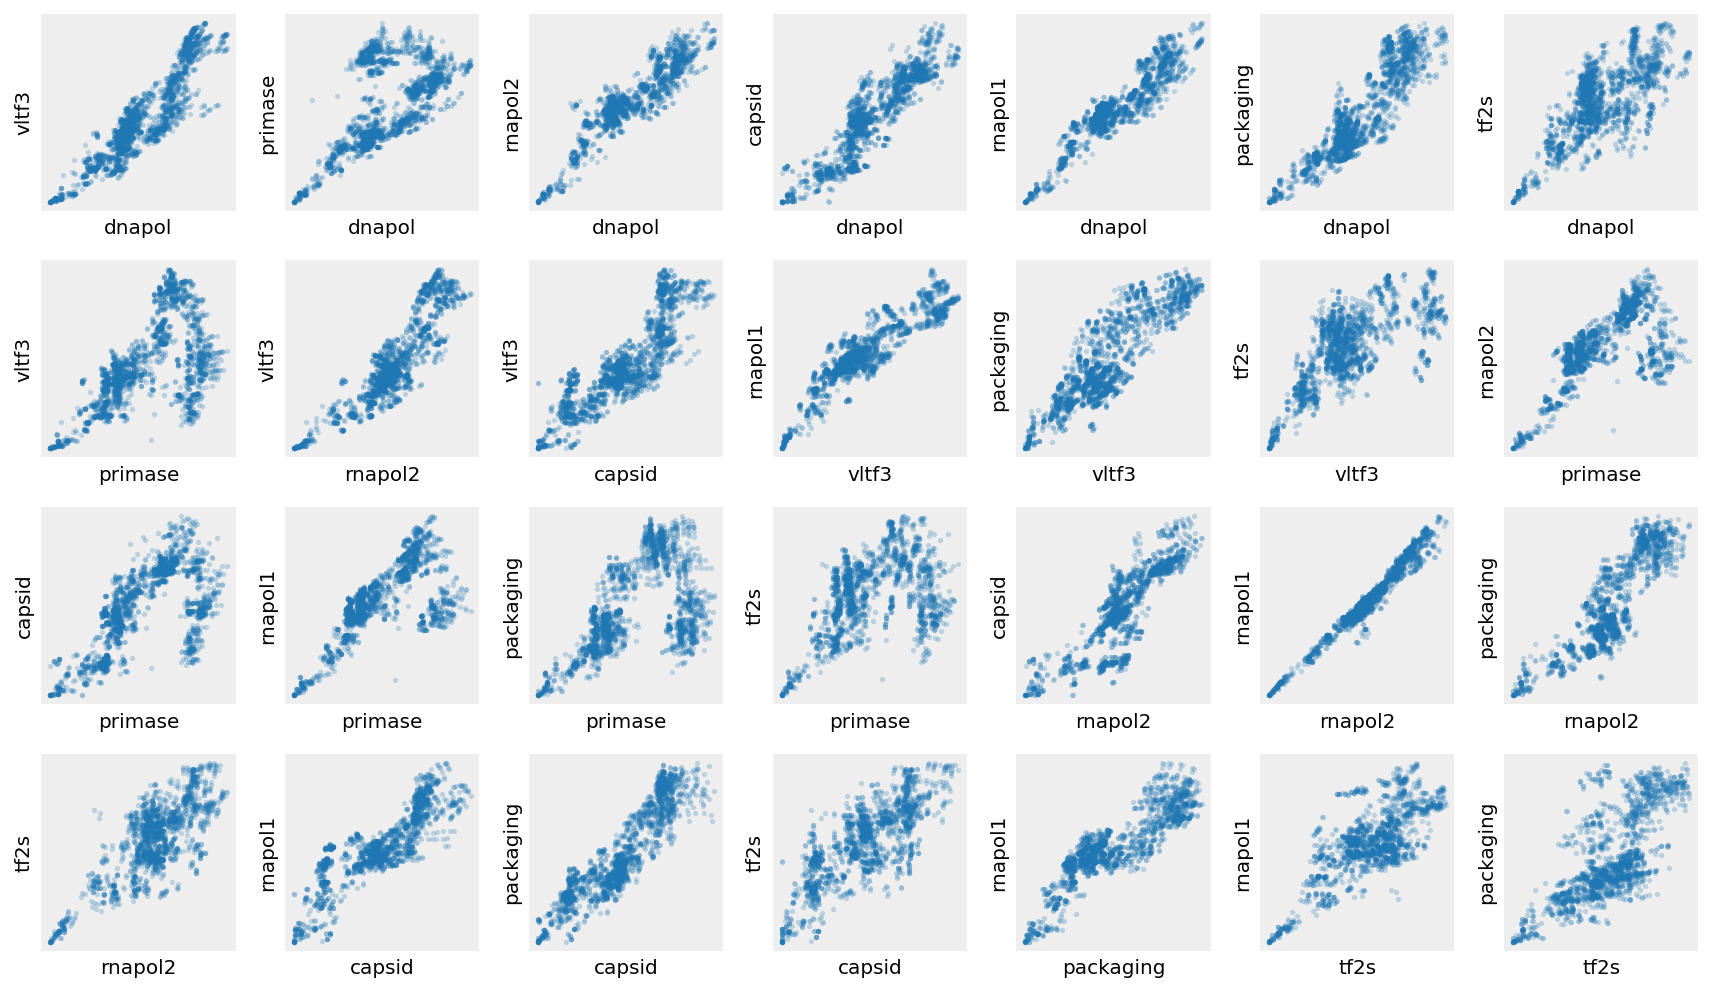

In [171]:
figure( figsize=(12,7) )
for n,I in enumerate( distances.keys() ) :
    ax = subplot( 4, 7, n + 1 )
    #ax.axis( 'off' )
    ax.set_facecolor( '#eeeeee' )
    for axis in ['top', 'bottom', 'left', 'right'] :
        ax.spines[axis].set_linewidth(0)
    xticks( [] )
    yticks( [] )
    x,y = I
    #title( x.split('-final.')[0] + '\nvs.\n' + y.split('-final.')[0] )
    xlabel( x.split('-final.')[0] )
    ylabel( y.split('-final.')[0] )
    scatter( distances[I][x], 
             distances[I][y],
             alpha=0.25, lw=0, s=7 )
tight_layout()

As you can see, all of these plots show obvious positive correlations. That means that when a pair of
orthologs are distant from each other in one tree, they also tend to be distant from one another in the
other tree. When a pair of orthologs are close together in one tree, they tend to be close together in
the other. 

You can also clearly see some complexity in these relationships. For example, the D5-like 
primase-helicase tree seems to have a slightly divergent topology from the other genes. You can also see
that RNAP-I and RNAP-II have extremely similar topologies. Now that we've turned our tree topologies
into a bunch of simple distances, we can cluster them by a correlation metric like Pearson's $r$ or
Kendall's $\tau$.

In [174]:
congruences_r = numpy.zeros( ( len(forest), len(forest) ) )
pvalues_r     = numpy.zeros( ( len(forest), len(forest) ) )
congruences_t = numpy.zeros( ( len(forest), len(forest) ) )
pvalues_t     = numpy.zeros( ( len(forest), len(forest) ) )
for i,a in enumerate( forest.keys() ) :
    T1 = forest[a]
    for j,b in enumerate( forest.keys() ) :
        T2 = forest[b]
        leafs = set( T1.leafs.keys() ) & set( T2.leafs.keys() )
        X = T1.distances_by_name( list( combinations( leafs, 2 ) ) )
        Y = T2.distances_by_name( list( combinations( leafs, 2 ) ) )
        congruences_r[i,j], pvalues_r[i,j] = pearsonr( X, Y )
        congruences_t[i,j], pvalues_t[i,j] = kendalltau( X, Y )

names = [ name.split('-final.')[0] for name in forest.keys() ]
cong_r = pandas.DataFrame( congruences_r, columns=names, index=names )
pv_r   = pandas.DataFrame( pvalues_r,     columns=names, index=names )
cong_t = pandas.DataFrame( congruences_t, columns=names, index=names )
pv_t   = pandas.DataFrame( pvalues_t,     columns=names, index=names )

I prefer Kendall's $\tau$ for this kind of correlation. Usually people use the product-moment
correlation, Pearson's $r$, for pretty much everything involving correlations. It 
bothers me that $r$ assumes that the underlying variables are normally distributed, though.
Kendall's $\tau$ is a rank-order correlation, so it gives you a similar look at the data
with fewer assumptions about the underlying processes.

In [176]:
cong_t

,dnapol,vltf3,primase,rnapol2,capsid,rnapol1,packaging,tf2s
dnapol,1.000000,0.744157,0.474433,0.719142,0.740635,0.744651,0.689265,0.488449
vltf3,0.744157,1.000000,0.437145,0.698499,0.689426,0.721375,0.664475,0.480128
primase,0.474433,0.437143,1.000000,0.509217,0.491716,0.522670,0.384383,0.305135
rnapol2,0.719142,0.698499,0.509217,1.000000,0.707573,0.874888,0.664289,0.496590
capsid,0.740635,0.689426,0.491716,0.707573,1.000000,0.696898,0.744595,0.560545
rnapol1,0.744651,0.721375,0.522670,0.874886,0.696898,1.000000,0.690486,0.480924
packaging,0.689265,0.664475,0.384383,0.664289,0.744597,0.690486,1.000000,0.571872
tf2s,0.488449,0.480128,0.305135,0.496591,0.560545,0.480923,0.571872,1.000000


In [179]:
pv_t.max()

dnapol       1.216943e-259
vltf3        2.395181e-247
primase      1.469356e-102
rnapol2      3.504976e-237
capsid       3.221986e-287
rnapol1      1.375121e-222
packaging    2.509967e-176
tf2s         1.469356e-102
dtype: float64

Even though some of these correlations are below 0.5, they are *hella* significant.
Kendall's $\tau$ tends to produce lower correlations and higher $p$-values than
you're probably used to seeing from Pearson's $r$, so I think these are extremely
convincing.

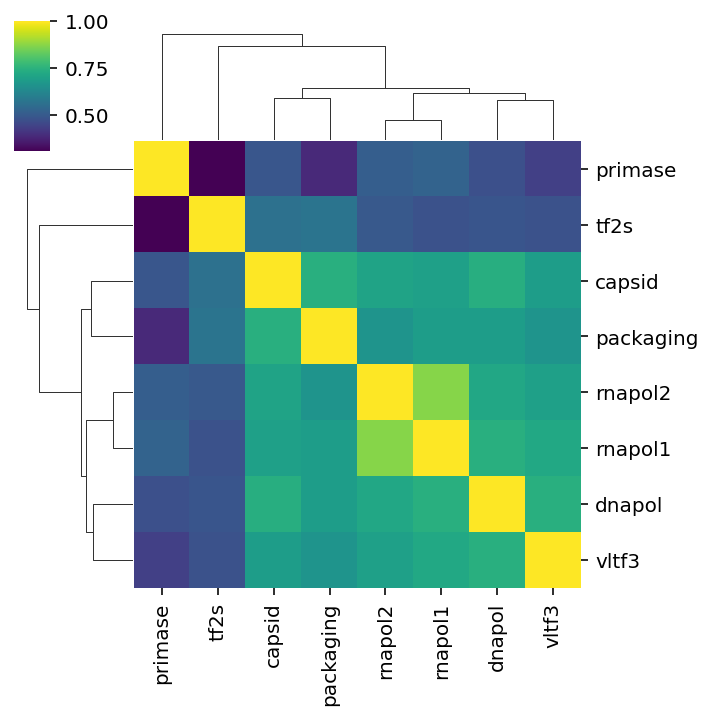

In [134]:
seaborn.clustermap( cong_t, figsize=(5,5), cmap='viridis' )

As expected, D5-like primase-helicase has the most divergent topology, followed by the 
transcription elongation factor gene tree. It is worth noting that these two genes
also have the shortest sequences, so I am quite curious how this would look if we performed
this analysis using all the bootstrap trees instead of just the "best" tree. Perhaps the 
slightly divergent topologies of the primease and elongation factor trees are simply a question
of precision, rather than accuracy, and would wash out when comparing populations of trees?

Anyway, I think we can conclude that these eight genes really do have highly congruent 
topologies. For Morgan's paper, the identification of the eight core genes relied heavily
on prior knowledge of viral physiology and evolution. The argument would be more compelling,
or at least more obvious, if it were presented in the context non-core genes. It makes sense
they were not presented this way in the paper -- with a manual selection process, choosing 
non-core genes would essentially be cherry-picking a background to make the selected core 
genes look more core-ish. However, if one were to conduct a systematic search for core genes
by clustering all NCLDV gene trees by topological congruence, that would be a different 
thing altogether! `SuchTree` is fast enough to do two or three _trillion_ times as many tree
traversals before I'd have to think about plugging in my laptop, so I'm pretty excited about
this line of thinking.

However, this pairwise approach does have a drawback for comparing very large numbers of
trees. To do this properly, a 
[Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction)
ought to be applied to the $p$-values for each of the correlations. Fortunately, there are
methods that are both more robust and more sensitive for clustering trees, but that will
be a topic for another article!